# Tensorflow for Image Classification

Code referenced: [ZALCODE](https://www.kaggle.com/code/zalcode/super-simple-butterfly-image-classification#Project-Description)

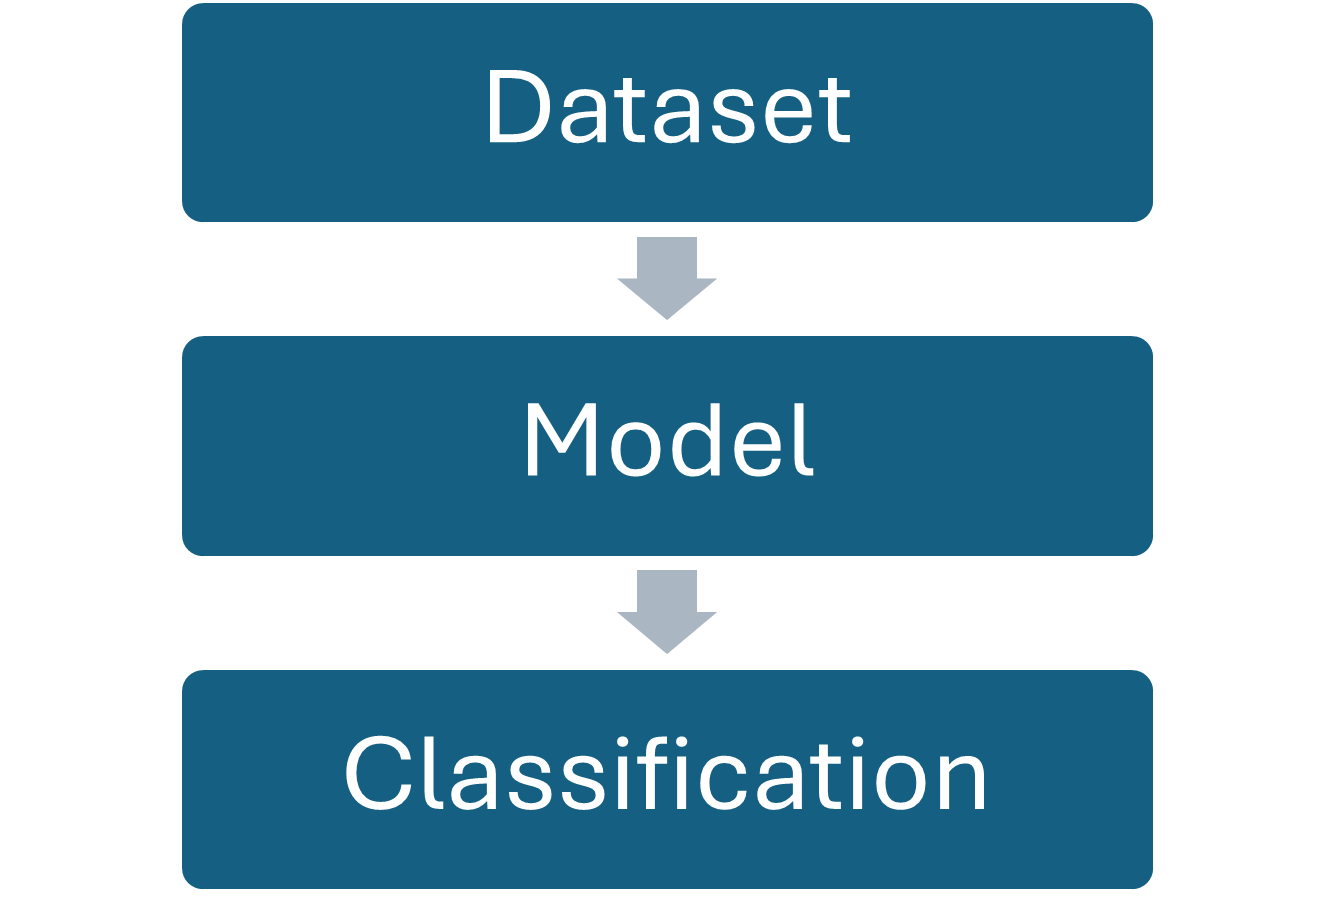 

Summary: Make Image Classification from Tensorflow's Model to classify between achiral and chiral molecules.

In [47]:
# pip install tensorflow

## Import modules

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# 1) Dataset

## Import and View Dataset

In [49]:
import pandas as pd

df_molecules = pd.read_csv("C:/Users/journ/Desktop/sandbox/Tf_molecules_6_24/tf_classify_6_25.csv")
df_molecules

,file_name,label
0,image_1.PNG,achiral
1,image_2.PNG,achiral
2,image_3.PNG,chiral
3,image_4.PNG,chiral
4,image_5.PNG,chiral
5,image_6.PNG,achiral
6,image_7.PNG,achiral
7,image_8.PNG,achiral
8,image_9.PNG,chiral
9,image_10.PNG,achiral


In [50]:
df_molecules['path'] = 'C:/Users/journ/Desktop/sandbox/Tf_molecules_6_24/train/' + df_molecules['file_name']
df_molecules

,file_name,label,path
0,image_1.PNG,achiral,C:/Users/journ/Desktop/sandbox/Tf_molecules_6_...
1,image_2.PNG,achiral,C:/Users/journ/Desktop/sandbox/Tf_molecules_6_...
2,image_3.PNG,chiral,C:/Users/journ/Desktop/sandbox/Tf_molecules_6_...
3,image_4.PNG,chiral,C:/Users/journ/Desktop/sandbox/Tf_molecules_6_...
4,image_5.PNG,chiral,C:/Users/journ/Desktop/sandbox/Tf_molecules_6_...
5,image_6.PNG,achiral,C:/Users/journ/Desktop/sandbox/Tf_molecules_6_...
6,image_7.PNG,achiral,C:/Users/journ/Desktop/sandbox/Tf_molecules_6_...
7,image_8.PNG,achiral,C:/Users/journ/Desktop/sandbox/Tf_molecules_6_...
8,image_9.PNG,chiral,C:/Users/journ/Desktop/sandbox/Tf_molecules_6_...
9,image_10.PNG,achiral,C:/Users/journ/Desktop/sandbox/Tf_molecules_6_...


In [51]:
df_molecules.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  10 non-null     object
 1   label      10 non-null     object
 2   path       10 non-null     object
dtypes: object(3)
memory usage: 368.0+ bytes


In [52]:
#assign numbers to labels classificaiton
molecule_class_num = df_molecules['label'].nunique()

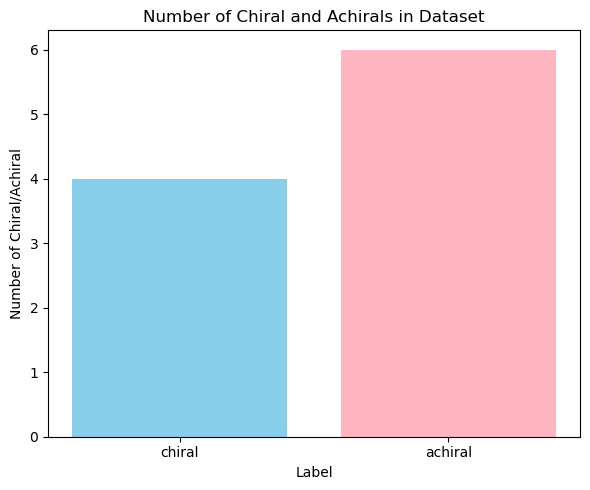

In [53]:
# Although I already know the dataset, it is good practice to see distribution of items per classificaiton

# Assuming the first column contains the labels (good or bad)
labels = df_molecules.iloc[:, 1]

# Count the number of "good" and "bad" fruits
n_chiral = (labels == "chiral").sum()
n_achiral = (labels == "achiral").sum()

# Create a list for categories
categories = ["chiral", "achiral"]

# Create a list for counts
counts = [n_chiral, n_achiral]

# Create the bar chart
plt.figure(figsize=(6, 5)) 
plt.bar(categories, counts, color=['skyblue', 'lightpink'])  
plt.xlabel("Label")
plt.ylabel("Number of Chiral/Achiral")
plt.title("Number of Chiral and Achirals in Dataset")
plt.xticks(rotation=0)  
plt.tight_layout()


plt.show()

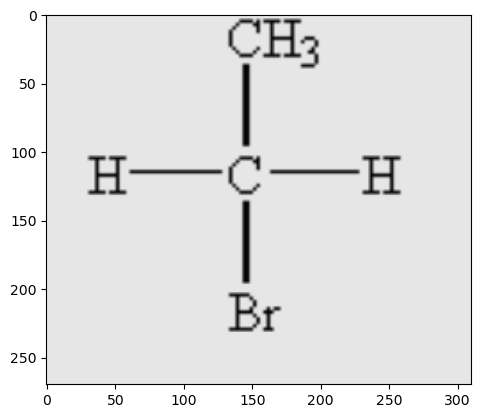

In [54]:
#show first image
from tensorflow.keras.preprocessing import image

myImage = image.load_img(r"C:/Users/journ/Desktop/sandbox/Tf_molecules_6_24/train/image_1.PNG")
plt.imshow(myImage)

## Split csv Dataset Train-Test

80:20 is default. This means 80% of the total datapoints is used to teach the model which belongs in what and 20% of the dataset not including the used 80% is used to test how well the model can classify each image to their labels.

In this case, 50:50 will be used to determine how well the model performs under such unideal conditions.

In [55]:
from sklearn.model_selection import train_test_split

train_data, validation_data = train_test_split(df_molecules, test_size=0.5, random_state=42)
print("50:50 split used.")

50:50 split used.


## Function for Data Preparation

Rescale 1/255 -> allows CNN to process images pixels on scale 0 - 1

Batch_size -> how many items to bunch together when running it through model for training
* I chose 1 to test how accurate the model would predict images labels since this learns images one by one. However, this utilizes a high level of computational cost.

class_mode -> how to label the images (binary 0/1 or as strings)

In [56]:
# def prep_data(train_data, validation_data, batch_size=1):
#     """
#     Prepares training and validation data using ImageDataGenerator
#     """

#     # Create ImageDataGenerator for training set
#     train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
#     train_set = train_datagen.flow_from_dataframe(
#         dataframe=train_data,
#         x_col='path',
#         y_col='label',
#         target_size=(128, 128),
#         batch_size=batch_size,
#         class_mode='sparse'
#     )

#     # Create ImageDataGenerator for validation set
#     validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
#     validation_set = validation_datagen.flow_from_dataframe(
#         dataframe=validation_data,
#         x_col='path',
#         y_col='label',
#         target_size=(128, 128),
#         batch_size=batch_size,
#         class_mode='sparse'
#     )

In [57]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def prep_data(train_data, validation_data, batch_size=1):
    # Create ImageDataGenerator for training set
    train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
    train_set = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        x_col='path',
        y_col='label',
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='sparse')

    # Create ImageDataGenerator for validation set
    validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
    validation_set = validation_datagen.flow_from_dataframe(
        dataframe=validation_data,
        x_col='path',
        y_col='label',
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='sparse')

    return train_set, validation_set

## Function for Learning Visualization

This will out put two line graphs, the former being the acccuracy graph with training and validation datasets and the latter being the loss with training and validation datasets. This graphs points for each succesive epoch completed. 

In [72]:
# visulization function for Models
def visualize(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    axs[0].plot(epochs, acc, 'r', label='Training acc')
    axs[0].plot(epochs, val_acc, 'b', label='Validation acc')
    axs[0].set_title('Training and validation accuracy')
    axs[0].legend()
    axs[0].grid(True)
    
    axs[1].plot(epochs, loss, 'r', label='Training loss')
    axs[1].plot(epochs, val_loss, 'b', label='Validation loss')
    axs[1].set_title('Training and validation loss')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()

## Visualizing the data 

Only one can be shown since i set batch_size = 1

In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_set, validation_set = prep_data(train_data, validation_data)

# Accessing the data
images, labels = next(train_set)

# Retrieving class names
class_names = train_set.class_indices
class_names = {v: k for k, v in class_names.items()}

Found 5 validated image filenames belonging to 2 classes.
Found 5 validated image filenames belonging to 2 classes.


In [60]:
train_set

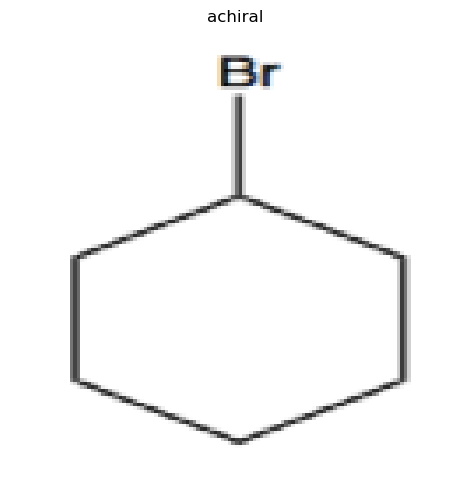

In [61]:
# Create a figure with one subplot (1 row, 1 column)
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))  # Adjust figsize as needed

# Choose which image and label to display (modify index if needed)
index_to_show = 0  # Change this to select a different image (0 or 1)

# Display the image on the subplot
ax.imshow(images[index_to_show])

# Get the class name and set the subplot title
label_index = int(labels[index_to_show])
class_name = class_names[label_index]
ax.set_title(f"{class_name}")

# Turn off axes for cleaner visualization (optional)
ax.axis('off')

# Adjust layout (optional, might not be needed with one subplot)
plt.tight_layout()

# Display the plot
plt.show()

# 2) Model

Reference code: [VASANT VOHRA](https://www.kaggle.com/code/vasantvohra1/transfer-learning-using-mobilenet)

There are three pre-trained models that are good to start off with for image classification:
* VGG16
* ResNet50
* Inception V3

However, my dataset is small. In theory, I would chose to use MobileNet as these models are used for larger datasets. As of now, I could only work with Inception V3.

### Explanation of hyperparameters:

**input_shape**: size of images we are inputting into model, 3 = RGB. If it was only black we only use 1 where it is only 1 pixel that only varies in intensity of its color.

**alpha**: # of filters for model to analyze input images when being trained. Filters analyze a small section of an image then categorize all of that data into 1 value and repeat for other sections of an image. 1 is default.

**depth_multiplier**: This controls the number of layers a model has to study the details and features of an image. 1 is default.

**dropout**: This controls how many nodes will be dropped the model during training. This prevents overfitting as some active nodes won't rely on its connections to the dropped nodes for model training. A small number is used here (.001).

**include_top**: This determines whether to include the pre-trained classification layers on top of the MobileNet model.

**weights**='imagenet' (or None): This specifies which pre-trained weights to load into the model.
'imagenet' loads the weights pre-trained on the ImageNet dataset (recommended for feature extraction).
None initializes the model with random weights (useful if you want to train the entire model from scratch on your own data).

**input_tensor**: If one wants to input their own pre-processed image prepared in a customized way. 

**pooling**: summarizing the information in a small region of an image to create a more condensed representation.

**classes**: number of outputs from dataset

**classifier_activation**: activation function used in the final classification layer.

In [62]:
from tensorflow.keras.applications import InceptionV3
# from tensorflow.keras.applications import MobileNet

base_model = InceptionV3(weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3))

In [63]:
# base_model = tf.keras.applications.MobileNet(
#     input_shape=(128,128,3),
#     alpha=1.0,
#     depth_multiplier=1,
#     dropout=0.001,
#     include_top=True,
#     weights=None,
#     input_tensor=None,
#     pooling=None,
#     classes=2,
#     classifier_activation='softmax'
# )

In [64]:
base_model.trainable = False  # Freeze all layers by default
for layer in base_model.layers[:10]:  # Unfreeze the last 10 layers for training (adjust as needed)
    layer.trainable = True

In [65]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy


model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(molecule_class_num, activation='softmax'))

# #fix lr to learning_rate

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00005), 
    metrics=['accuracy']
)

In [66]:
# from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D, Dense

# model = Sequential([
#     base_model,
#     Conv2D(128, 3, activation='relu'),
#     Dropout(0.2),
#     GlobalAveragePooling2D(),
#     Dense(2, activation='softmax')  # 2 classes (chiral/achiral)
# ])

In [67]:
# from tensorflow.keras.optimizers import RMSprop
# from tensorflow.keras.losses import CategoricalCrossentropy
# from tensorflow.keras.metrics import Accuracy

# #fix lr to learning_rate

# model.compile(optimizer=RMSprop(learning_rate=0.0001),
#               loss=CategoricalCrossentropy(),
#               metrics=[Accuracy()])

# 3) Classification

In [68]:
# had to relabel categories from strings to numbers

model_v1 = model.fit(
    train_set,
    epochs=10,
    validation_data=validation_set,
    )

Epoch 1/10
2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.1929

C:\Users\journ\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 636ms/step - accuracy: 0.8250 - loss: 1.1084 - val_accuracy: 0.6000 - val_loss: 1.1241
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 1.0000 - loss: 0.1339 - val_accuracy: 0.4000 - val_loss: 1.2363
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 1.0000 - loss: 0.0330 - val_accuracy: 0.2000 - val_loss: 1.3454
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 0.0164 - val_accuracy: 0.2000 - val_loss: 1.4504
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 1.0000 - loss: 0.0113 - val_accuracy: 0.2000 - val_loss: 1.4812
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 1.0000 - loss: 0.0095 - val_accuracy: 0.2000 - val_loss: 1.5506
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 1.0000 - loss: 0.0085 - val_accuracy: 0.2000 - val_loss: 1.6483
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 0.2000 - val_loss: 1.6888
Epoch 9/

## Training and Validation Accuracy 

**Analysis**:

The model was able to learn the training dataset well as there was 100% accuracy on the 2nd epoch. This makes sense due to the low learning rate and small training dataset of 5 items. However, this was not condusive for evaluating the model's performance as it's accuracy for the validation dataset (ds) significantly decreased from 60% to 20%. Furthermore, the validation loss increased with the number of epochs.

To resolve this, I could increase the number of items in the dataset to then do a 80:20 split train:test on it for proper classification.

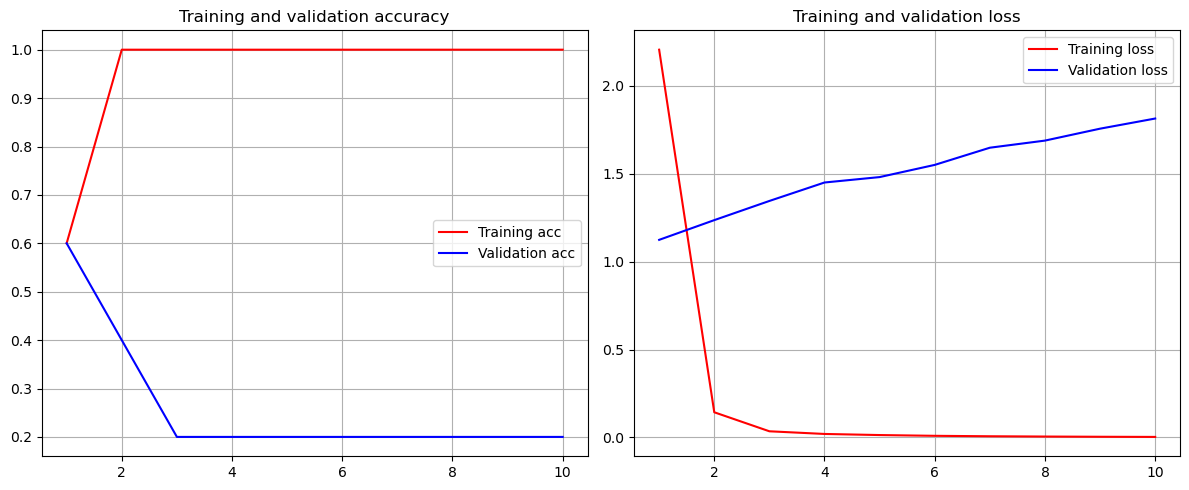

In [73]:
visualize(model_v1)